# Disaster tweets comp: introduction to NLP

The aim of this notebook is to classify tweets potentially related to catastrophes into real or misleading tweets. It may also serve as an introduction to Natural Language Processing (NLP), since it covers several data cleaning techniques and classification algorithms in order to conclude which combinations are the most succesfull.The spirit of this notebook is not to obtain a top LB score, but to learn how to deal with text data, decide which techniques are more suited for this project and why others are not recommended from a beginner perspective. 

Hope you enjoy it and, if you like this work, I'll be glad if you upvote it. Let's begin!


**TABLE OF CONTENTS**

1. [Bag of words (BOW)](#section1)

    * [Load data](#section11)
    
    * [Brief EDA](#section12)
    
    * [BOW and logistic prediction regression](#section13)


2. [Text data cleaning](#section2)

    * [Lowercasing](#section21)
    
    * [Normalization](#section22)
  
    * [Stop-word removal](#section23)
    
    * [Lemmatization](#section24)


3. [Term frequency - Inverse document frequency (TFIDF)](#section3)


4. [Comparison of classification models](#section4)


5. [Word embeddings](#section5)

    * [Word embeddings](#section51)
    
    * [Linear SVC model](#section52)


6. [Recurrent neural networks (RNN)](#section6)


Import the required libraries:

In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

# Libraries for data cleaning
import unidecode
import re
import string
!pip install pycontractions
from pycontractions import Contractions
import gensim.downloader as api
# Choose model accordingly for contractions function
model = api.load("glove-twitter-25")
# model = api.load("glove-twitter-100")
# model = api.load("word2vec-google-news-300")
cont = Contractions(kv_model=model)
cont.load_models()
import operator

# NLP libraries
import spacy
from spacy.lang.en import English
!pip install pyspellchecker
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords

# ML libraries
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# NN libraries
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

  Created wheel for language-check: filename=language_check-1.1-py3-none-any.whl size=90190895 sha256=ae69fc835ac4e6f6ae2bf5b90be720d2de05cefee1e452ff03f162e5de7de6cf
  Stored in directory: /root/.cache/pip/wheels/ce/fe/32/3b83a67c4f1182f7f6aa134c1d04cdcd893072bdadb4f5a64c
Successfully built language-check
[======================----------------------------] 44.2% 46.3/104.8MB downloaded

In [2]:
# List of files (including output files)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_clean
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/__results__.html
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/submission_svc_basic.csv
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/__output__.json
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/custom.css
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_lemmatized
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/__notebook__.ipynb
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_normalized
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/submission_logistic_basic.csv
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_lowercased
/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_no_stopwords
/kaggle/input/disaster-tweets-comp-introduction

# 1. Bag of words (BOW) <a id="section1"></a>

A simple procedure when working with language data is to compute a **bag of words (BOW)**, that consists on creating one column for each word and keeping track of when they appear in the tweets. This will be our first approach given that it's a common technique in NLP projects, significantly fast and works fine without many data cleaning. 

Once the  BOW has been created, we will train a **logistic regression** model and evaluate the performance of the predictions.

Steps in this section:
* 1.1. Load data
* 1.2. Brief EDA
* 1.3. BOW and logistic regression prediction

## 1.1. Load data <a id="section11"></a>

First of all, let's read the data and take a look on its structure.

In [3]:

# test = pd.read_csv("test.csv")
train = pd.read_csv("sentiment_nlp.csv.csv")

print("Train dataset size: ", len(train))
# print("Test dataset size: ", len(test))

# A brief look on the train dataset
train[90:100]

Train dataset size:  7613
Test dataset size:  3263


,id,keyword,location,text,target
90,132,accident,NaN,???? it was an accident http://t.co/Oia5fxi4gM,0
91,133,accident,"New Hanover County, NC",FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;WPD;160...,1
92,134,accident,NaN,8/6/2015@2:09 PM: TRAFFIC ACCIDENT NO INJURY a...,1
93,135,accident,global,Aashiqui Actress Anu Aggarwal On Her Near-Fata...,1
94,136,accident,Alberta | Sask. | Montana,Suffield Alberta Accident https://t.co/bPTmlF4P10,1
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0
99,143,accident,NaN,only had a car for not even a week and got in ...,1


## 1.2. Brief EDA <a id="section12"></a>

The dataset contains only 3 relevant features, and most of the useful information is contained in the text column. Hence, let's keep things simple and explore only the surface of this data. A few question to answer:
* How many different locations?
* How many different keywords?
* Is the target class balanced? Number of real tweets vs fake tweets
* Has the dataset missing values?

Number of unique locations:  4521
Number of unique keywords:  221
Percentage of real disaster tweets:  42.96597924602653
Missing values:


id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

Text(0.5, 0, 'Target')

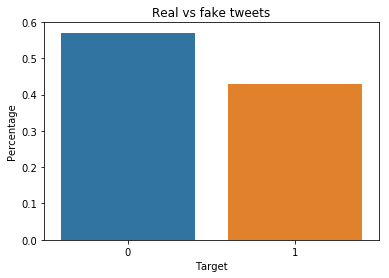

In [4]:
# Join  train and test datasets to analyze all data in single commands
all_data = pd.concat([train,test], axis = 0, sort=False)

# How many locations/keywords?
print("Number of unique locations: ", all_data.location.nunique())
print("Number of unique keywords: ",all_data.keyword.nunique())

# Check data balance; frequency of real disaster tweets (target=1)
print("Percentage of real disaster tweets: ", all_data.target.sum()/len(train)*100)

# Find missing values in a single code line,
print("Missing values:")
display(all_data.isna().sum())

ax = sns.barplot(train['target'].value_counts().index,train['target'].value_counts()/len(train))
ax.set_title("Real vs fake tweets")
ax.set_ylabel("Percentage")
ax.set_xlabel("Target")

**Conclusions**:
* There's almost half the number of locations than the number of data rows
* Not many different keywords
* Target variable is balanced (43% are real tweets)
* Some keywords are missing
* Almost 30% of the locations are missing

The most common keywords and locations may also give us some insight:

Text(0.5, 1.0, 'Top 15 locations')

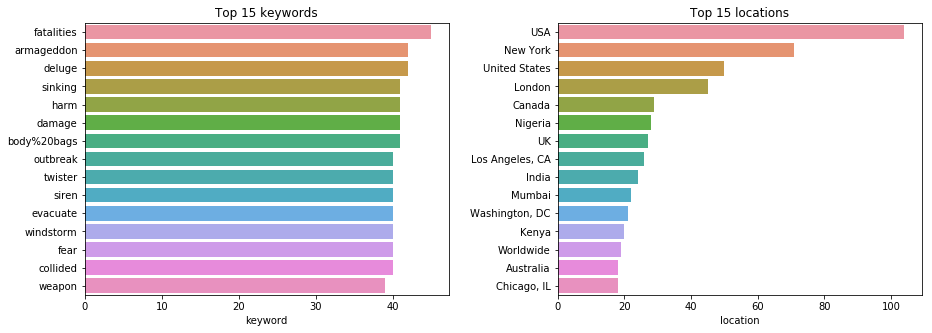

In [5]:
f1, axes = plt.subplots(1, 2, figsize=(15,5))
f1.subplots_adjust(hspace=0.4, wspace=0.3)
ax1 = sns.barplot(y=train['keyword'].value_counts()[:15].index,x=train['keyword'].value_counts()[:15],
            orient='h', ax=axes[0])
ax1.set_title("Top 15 keywords")
ax2 = sns.barplot(y=train['location'].value_counts()[:15].index,x=train['location'].value_counts()[:15],
            orient='h', ax=axes[1])
ax2.set_title("Top 15 locations")

Looks like there are some duplicates (i.e. USA/United States), and some USA countries are also specified (i.e. Chicago, IL). However, since locations have proven to contain lots of missing values, it's not worth working these duplicates. 

A more interesting task is to **replace missing values** in locations and keywords by the string "None".

In [6]:
# Fill missings for train and test datasets
all_data.location.fillna("None", inplace=True)
all_data.keyword.fillna("None", inplace=True)

# Fill the target column for the test rows. This will help us with future calls to model predictions
all_data.target.fillna(0, inplace=True)

## 1.3. BOW and logistic regression prediction <a id="section13"></a>

Data has been analysed and there are no missing values in the dataset. We could now proceed to analyze all columns in order to classify tweets into real or misleading disaster tweets, and even extract some additional features (number of words, number of punctuation marks, etc). However, since we are interested in the language treatment of this dataset, **for the sake of simplicity I decided to focus only on the text column** and ignore the other ones. Notice that ignoring keywords, locations and engineered features may prevent our algorithms from obtaining better scores.

We are in disposition to **compute the bag of words** (BOW), split the dataset into a train/validation subsets and finally compute a **logistic regression model**. 

In [7]:
# Define the vectorizer counter that will compute the BOW
def count_vector(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


# Define a function for the logistic regression algorithm
def logreg_bow(data, valid_fraction):
    
    # Transform data to list
    list_corpus = data["text"].tolist()
    list_labels = data["target"].tolist()

    # Split train-validation data
    X_train, X_valid, y_train, y_valid = train_test_split(list_corpus, list_labels, 
                                                          test_size=valid_fraction, random_state=21)

    # Generate the bag of words through the count_vectorizer function
    X_train_counts, count_vectorizer = count_vector(X_train)
    X_valid_counts = count_vectorizer.transform(X_valid)

    # Run LogisticRegression model
    clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                             multi_class='multinomial', n_jobs=-1, random_state=21)
    clf.fit(X_train_counts, y_train)
    y_predicted_counts = clf.predict(X_valid_counts)
    
    # Cross validation score over 10 folds
    scores = cross_val_score(clf, X_train_counts, y_train, cv=10)
    print("Cross validation over 10 folds: ", scores, " --- ", sum(scores)/10.)

    return y_predicted_counts, y_valid


# Define a metrics function named get_metrics to evaluate the model's performance
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# Final call of the logistic regression model and metrics
y_predicted_logistic, y_val = logreg_bow(all_data[:len(train)], 0.2)
accuracy, precision, recall, f1 = get_metrics(y_val, y_predicted_logistic)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Cross validation over 10 folds:  [0.78817734 0.7635468  0.77011494 0.78981938 0.77668309 0.77339901
 0.74712644 0.77668309 0.77504105 0.79310345]  ---  0.7753694581280789
accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797


A validation accuracy of 0.797, quite good for such a simple model. Let's compute the prediction over the test dataset and submit the output file to obtain a LB score. 

In [8]:
def submit_logistic(outfile_name, data, test, valid_frac):
    
    # Run the LogisticRegression model
    y_pred, y_valid = logreg_bow(data, valid_frac)
    
    # Submit results
    submission = pd.DataFrame({
            "id": test.id, 
            "target": y_pred
        })
    submission.to_csv(outfile_name, index=False)
    
    return y_pred, y_valid
    
y_logistic_pred, y_logistic_test = submit_logistic("submission_logistic_basic.csv", all_data, test, len(test)/len(all_data))

Cross validation over 10 folds:  [0.73753281 0.74671916 0.7191601  0.73718791 0.73718791 0.74244415
 0.717477   0.71879106 0.73718791 0.72141919]  ---  0.731510721146716


Performance of the models:
* **Basic logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797

# 2. Text data cleaning <a id="section2"></a>

Despite being very simple, our first model has reached a reasonably good accuracy. Let's see if we can improve it by performing specific cleaning techniques for language data. 

Steps in this section:
* 2.1. Lowercasing
* 2.2. Normalization
* 2.3. Stop word removal
* 2.4. Lemmatization

**Note 1**: this techniques should not be considered as a mandatory procedure to apply in all NLP projects. Some of them could lead to lower performances depending on the specific nature of the problem, and that's why we are going to add them to the model independently in order to verify if the accuracy increases.

**Note 2**: to achieve a more readable code, we will compute everything based on generalized functions that include all the previous steps. Moreover, some of the cleaning techniques take some time to process the data, so that we will save one file per transformation.

## 2.1. Lowercasing <a id="section21"></a>

**Definition**: In order to allow the program to generalize words, transform all of them to lower case.

In [9]:
# Convert text column to lowercase
all_data2 = all_data.copy()
all_data2['text'] = all_data['text'].apply(lambda x: x.lower())
all_data2.head(5)
all_data2.to_csv("tweets_lowercased", index=False)

The tokenizer works fine, transforming all characters into lowercase. Does this transformation improves the model's performance?

In [10]:
y_logistic_lower, y_val = logreg_bow(all_data2[:len(train)], 0.2)
accuracy, precision, recall, f1 = get_metrics(y_val, y_logistic_lower)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Cross validation over 10 folds:  [0.78817734 0.7635468  0.77011494 0.78981938 0.77668309 0.77339901
 0.74712644 0.77668309 0.77504105 0.79310345]  ---  0.7753694581280789
accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797


**Conclusion**: lowercased text do not improve the logistic regression performance. However, it does not make it worse either.

Performance of the models:
* **Basic logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797
* **Lowercase logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797

## 2.2. Normalization <a id="section22"></a>

**Definition**: The jargon used in coloquial language, specially in social media, leads to either content not useful for NLP or to different versions of the same sentence but written in alternative ways. For example: punctuation marks, emojis, contractions, URLs, grammar errors... 

To normalize data and reduce noise, we will apply several transformations:
* **Remove accents**. Instead of receiving accented characters (latté) we just write plain letters.
* **Remove URL**. Most tweets may include links and such, it may be good to clean them.
* **Remove html**. Scratched data usually contains headers and marks (<br/), this should be removed.
* **Remove emojis**. Despite emojis are related to sentiments, they are abused and used in any type of tweet.
* **Remove punctuation**. All punctuation marks are deleted.
* **Expand contraction**s. Contractions like isn't are expanded to is not.
* **Spell checking**. Substitute wrong sentences (Am gona ned you) to correct ones (I am going to need you).

**Disclaimer**: the origin of several of the functions used in this subsection come from the awesome kernel of Shahules786; https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove. Please check it out for reckon.

In [11]:
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def expand_contractions(text):
    text = list(cont.expand_texts([text], precise=True))[0]
    return text

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

# Now compact all the normalization function calls into a single function
def normalization(text):
    text = remove_accented_chars(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_punct(text)
    text = expand_contractions(text)
    text = correct_spellings(text)
    return text

Once all the sub-processes have been defined, we just need to apply the normalization function:

In [12]:
ts = time.time()

all_data2 = all_data.copy()
all_data2['text'] = all_data['text'].apply(lambda x: normalization(x))
all_data2.head(5)
all_data2.to_csv("tweets_normalized", index=False)

print("Time spent: ", time.time() - ts)

Time spent:  5954.181267023087


Tweets have been correctly transformed according to our normalization rules. Do normalization increases the logistic regression performance?

In [13]:
y_logistic_norm, y_val = logreg_bow(pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_normalized")[:len(train)], 0.2)
accuracy, precision, recall, f1 = get_metrics(y_val, y_logistic_norm)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Cross validation over 10 folds:  [0.75697865 0.76683087 0.75041051 0.78489327 0.7454844  0.75697865
 0.74220033 0.76190476 0.74712644 0.78489327]  ---  0.7597701149425287
accuracy = 0.788, precision = 0.788, recall = 0.788, f1 = 0.788


**Conclusion**: looks like normalization has worsen the model's accuracy, as well as the rest of the metrics. Maybe some of the removed characters contained some useful information, so that we conclude that no normalization is required for the dataset.

Performance of the models:
* **Basic logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797
* **Lowercase logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797
* **Normalized logistic**:  cross_val_accuracy = 0.7599, accuracy = 0.788, precision = 0.788, recall = 0.788, f1 = 0.788

## 2.3. Stop word removal <a id="section23"></a>

**Definition**: Analogous to normalization, some words are merely argon based and do not add much value to sentences. For example: the, to, and,...

In order to remove stop words, we will use a powerful NLP library named spaCy. **SpaCy is able to recognise different languages**, split full texts into words (tokens) and extract additional features that we will review in the following sections. For now on, let's just use it for transformation purposes.

The first step to work with spaCy is to load the language model to use (see https://spacy.io/usage/models and https://spacy.io/usage/spacy-101 for detailed info), in our case English. This sets up the specific rules of the language in order to perform the **tokenization**.

In [14]:
# Load the spacy model to get sentence vectors
nlp = spacy.load('en_core_web_lg')

The SpaCy library contains an in-built stop word function, so that removing these words is very simple:

In [15]:
def remove_stopwords(text):
    tokens = [token.text for token in text if not token.is_stop]
    return ' '.join([token for token in tokens])

ts = time.time()
all_data2 = all_data.copy()
all_data2['text'] = all_data['text'].apply(lambda x: remove_stopwords(nlp(x)))
all_data2.head(5)
all_data2.to_csv("tweets_no_stopwords", index=False)
print("Time spent: ", time.time() - ts)

Time spent:  112.17420625686646


Stopwords are succesfully removed from the tweets text. Let's see if this improves the performance:

In [16]:
y_logistic_stop, y_val = logreg_bow(pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_no_stopwords")[:len(train)], 0.2)
accuracy, precision, recall, f1 = get_metrics(y_val, y_logistic_stop)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Cross validation over 10 folds:  [0.77832512 0.77175698 0.75533662 0.80788177 0.78817734 0.77175698
 0.74876847 0.76518883 0.77504105 0.80952381]  ---  0.777175697865353
accuracy = 0.787, precision = 0.786, recall = 0.787, f1 = 0.786


**Conclusion**: removing stopwords has slightly increased the cross validation accuracy. Other metrics are also improved, so that we conclude that stop word removal helps the model to predict real disaster tweets. 

Performance of the models:
* **Basic logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797
* **Lowercase logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797
* **Normalized logistic**:  cross_val_accuracy = 0.7599, accuracy = 0.788, precision = 0.788, recall = 0.788, f1 = 0.788
* **No stopwords logistic**:   cross_val_accuracy = 0.7755, accuracy = 0.787, precision = 0.786, recall = 0.787, f1 = 0.786

## 2.4. Lemmatization <a id="section24"></a>

**Definition**: Several words share a common root, but their slight differences are not very important. Hence, lemmatization translates all these words into their root form, so that models are not confused by different versions. For example: bad and worse, or flying, flew and flown.

Again, we will use Spacy, since it automatically computes the lemma of each word. Analogously to stop words, obtaining the lemma is very easy:

In [17]:
def lemmatizer(text):
    tokens = [token.lemma_ for token in text]
    return ' '.join([token for token in tokens])

ts = time.time()
all_data2 = all_data.copy()
all_data2['text'] = all_data['text'].apply(lambda x: lemmatizer(nlp(x)))
all_data2.head(5)
all_data2.to_csv("tweets_lemmatized", index=False)
print("Time spent: ", time.time() - ts)

Time spent:  102.94515037536621


Lemmatization has tranformed all words into their root form. Once a model is run, it will recognize the meaning of the words but ignoring specific conjugations and alternative forms. Our next objective is to verify if the accuracy is improved.

In [18]:
y_logistic_lemma, y_val = logreg_bow(pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_lemmatized")[:len(train)], 0.2)
accuracy, precision, recall, f1 = get_metrics(y_val, y_logistic_lemma)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Cross validation over 10 folds:  [0.78981938 0.76190476 0.76190476 0.7816092  0.77339901 0.7865353
 0.75205255 0.77504105 0.78325123 0.80131363]  ---  0.7766830870279146
accuracy = 0.789, precision = 0.789, recall = 0.789, f1 = 0.789


**Conclusion**: lemmatization has proved to slightly increase the tweets classification process. We will apply lemmatization in future models. From all the techniques, normalization is the only one that has provided a lower accuracy. Hence, we conclude that we should avoid normalization for this dataset.

Performance of the models:
* **Basic logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797
* **Lowercase logistic**:  cross_val_accuracy = 0.7754, accuracy = 0.797, precision = 0.797, recall = 0.797, f1 = 0.797
* **Normalized logistic**:  cross_val_accuracy = 0.7598, accuracy = 0.788, precision = 0.788, recall = 0.788, f1 = 0.788
* **No stopwords logistic**:   cross_val_accuracy = 0.7772, accuracy = 0.787, precision = 0.786, recall = 0.787, f1 = 0.786
* **Lemmatized logistic**:   cross_val_accuracy = 0.7767, accuracy = 0.776, precision = 0.776, recall = 0.776, f1 = 0.776

# 3. Term frequency - Inverse document frequency (TFIDF) <a id="section3"></a>

Data cleaning has demonstrated its utility, but also that it's important to explore which techniques are suitable for our problem. In order to keep getting better results, we'll try a subtle modification of the BOW named **term frequency, inverse document frequency (TF-IDF)**. 

Analogous to BOW, TF-IDF creates one column for each word, but this time the weight is averaged by both the frequency of the word and the number of cases in which it appears. Hence, if there are multiple occurrences of a certain word, but it's common in most of the texts, then the weight is lowered. 

In [19]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

def logreg_tfidf(data, valid_fraction):
    
    # Transform data to list
    list_corpus = data["text"].tolist()
    list_labels = data["target"].tolist()
    
    # Split train-validation data
    X_train, X_valid, y_train, y_valid = train_test_split(list_corpus, list_labels, 
                                                          test_size=valid_fraction, random_state=21)

    # Compute the tfidf vectors
    X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
    X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

    # Run the logistic regression model
    clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                             multi_class='multinomial', n_jobs=-1, random_state=21)
    clf_tfidf.fit(X_train_tfidf, y_train)

    y_predicted_tfidf = clf_tfidf.predict(X_valid_tfidf)
    
    # Cross validation score over 10 folds
    scores = cross_val_score(clf_tfidf, X_train_tfidf, y_train, cv=10)
    print("Cross validation over 10 folds: ", sum(scores)/10.)
    
    return y_predicted_tfidf, y_valid

In order to properly analyze the results of the TF-IDF transformation, we will run the logistic regression model for all the data cleaning cases:

In [20]:
print("Basic model")
y_predicted_tfidf, y_valid = logreg_tfidf(all_data[:len(train)], 0.2)

print("Lowercased model")
y_predicted_tfidf, y_valid = logreg_tfidf(pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_lowercased")[:len(train)], 0.2)

print("Normalized model")
y_predicted_tfidf, y_valid = logreg_tfidf(pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_normalized")[:len(train)], 0.2)

print("No stopwords model")
y_predicted_tfidf, y_valid = logreg_tfidf(pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_no_stopwords")[:len(train)], 0.2)

print("Lemmatized model")
y_predicted_tfidf, y_valid = logreg_tfidf(pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_lemmatized")[:len(train)], 0.2)

Basic model
Cross validation over 10 folds:  0.7773399014778325
Lowercased model
Cross validation over 10 folds:  0.7773399014778325
Normalized model
Cross validation over 10 folds:  0.7674876847290639
No stopwords model
Cross validation over 10 folds:  0.777832512315271
Lemmatized model
Cross validation over 10 folds:  0.7802955665024631


**Conclusion**: results are slightly better than in the BOW case, but they point into the same direction with respect to data cleaning. All  cleaning techniques have improved the model's accuracy, except for normalization. From now on, we will use a dataset with the **full cleaning but for normalization**.

# 4. Comparison of classification models <a id="section4"></a>

At this point, we are in disposition to conclude that the best results are obtained by a combination of TF-IDF and a certain data cleaning (no normalization). At least, that's what we observed from a Logistic regression model. But, what about other models? In this section we will analyze different classification algorithms to see which performs better in the tweets dataset.

Models to study:
* Naive Bayes
* Linear SVC
* KNN
* Random Forest
* XGBoost

Before starting with the predictions, we need to generate the clean tweet dataset to analyze (lowercasing + stop removal + lemmatization):

In [21]:
ts = time.time()

# Read the file with no stop words
clean_data = pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_no_stopwords")

# Lemmatize
clean_data['text'] = clean_data['text'].apply(lambda x: lemmatizer(nlp(x)))

# Lowercase
clean_data['text'] = clean_data['text'].apply(lambda x: x.lower())

clean_data.to_csv("tweets_clean", index=False)

print("Time spent: ", time.time() - ts)

Time spent:  95.30118370056152


Define a couple quality of life functions to split train/test data and get the cross validation score of any classification model:

In [22]:
# Define a tfidf and split function
def tfidf_split(data, valid_fraction):
    
    # Transform data to list
    list_corpus = data["text"].tolist()
    list_labels = data["target"].tolist()
    
    # Split train-validation data
    X_train, X_valid, y_train, y_valid = train_test_split(list_corpus, list_labels, 
                                                          test_size=valid_fraction, random_state=21)

    # Compute the tfidf vectors
    X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
    X_valid_tfidf = tfidf_vectorizer.transform(X_valid)
    
    return X_train_tfidf, X_valid_tfidf, y_train, y_valid

X_train, X_valid, y_train, y_valid = tfidf_split(clean_data[:len(train)], 0.2)


# Define a general call for the different models
def get_cross_val(model, X_train, X_valid, y_train, y_valid):
    
    # Fit on train, predict on validation
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    
    # Cross validation score over 10 folds
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print("Cross validation over 10 folds: ", sum(scores)/10.)
    
    return y_pred

Now, to obtain the cross validation score, we simply call the function **get_cross_val** for each of the models:

In [23]:
ts = time.time()

print("Logistic regression: ")
y_LR = get_cross_val(LogisticRegression(C=30.0, class_weight='balanced', 
                                        solver='newton-cg', multi_class='multinomial', 
                                        n_jobs=-1, random_state=21), 
                                        X_train.toarray(), X_valid.toarray(), y_train, y_valid)

print("\nNaive Bayes:")
y_bayes = get_cross_val(GaussianNB(), X_train.toarray(), X_valid.toarray(), y_train, y_valid)

print("\nSVC:")
y_SVC = get_cross_val(LinearSVC(random_state=21, dual=False), X_train, X_valid, y_train, y_valid)

print("\nKNN:")
y_KNN = get_cross_val(KNeighborsClassifier(n_neighbors=15), X_train, X_valid, y_train, y_valid)

print("\nRandom forest:")
y_RF = get_cross_val(RandomForestClassifier(random_state=21), X_train, X_valid, y_train, y_valid)

print("\nXGBoost:")
y_XGB = get_cross_val(XGBClassifier(n_estimators=1000, random_state=21), X_train, X_valid, y_train, y_valid)

print("Time spent: ", time.time() - ts)

Logistic regression: 
Cross validation over 10 folds:  0.7763546798029556

Naive Bayes:
Cross validation over 10 folds:  0.6021346469622332

SVC:
Cross validation over 10 folds:  0.789655172413793

KNN:
Cross validation over 10 folds:  0.777175697865353

Random forest:
Cross validation over 10 folds:  0.7821018062397372

XGBoost:
Cross validation over 10 folds:  0.7819376026272578
Time spent:  1765.5028131008148


**Conclusions**: All models have performed well except for Naive Bayes. The best scores are obtained by SVC, Random Forest and XGB. Notice that we performed no fine tunning of the parameters, which may affect the results (in particular for complex algorithms like XGB).

# 5. Word embeddings <a id="section5"></a>

Word embeddings (or word vectors) are a **transformation of words into vectors** based on large language models. Two vectors will be similar when their respective words share a common background; for example, queen and king have similar components, while queen and table don't. I strongly recommend [Mat's Kaggle course](https://www.kaggle.com/matleonard/word-vectors) for more details.

On the other hand, we will classify these vectors with  a **Support vector machine** (SVM). SVMs are machine learning algorithms that aim to find an hyperplane in a N-dimensional space, where N is the number of features, in order to classifiy data points into classes. SVM are both precise and fast when dealing with high dimensional datasets.

## 5.1. Word embeddings <a id="section51"></a>

To transform text into vectors we are going to use the spaCy library, that we previously used for the removal of stop-words. Notice that the word vector transformation is at the level of words, but in this project we are dealing with full sentences (tweets). To transform a whole text into a single vector, spaCy just computes the **average of all vectors (words) in a sentence to create the text vector**.

In [24]:
ts = time.time()
clean_data = pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_clean")
vectors = np.array([nlp(tweet.text).vector for idx, tweet in clean_data.iterrows()])
vectors.shape
print("Time spent: ", time.time() - ts)

Time spent:  99.90186953544617


Another detail to consider is that **language texts from a certain topic frequently share a lot of common words**. Hence, the different sentence vectors may be very similar to each other. To fix this, it is useful to compute the mean of all vectors (i.e. the whole dataset vector) and substract it from them:

In [25]:
# Center the vectors
vec_mean = vectors.mean(axis=0)
centered = pd.DataFrame([vec - vec_mean for vec in vectors])
print("Center shape: ", centered.shape)

Center shape:  (10876, 300)


## 5.2. Linear SVC model <a id="section52"></a>

Finally, data is relatively clean and has been transformed into vectors. The only task remaining is to feed these data into the SVM model, train it and finally submit the results from the test dataset.

We will use 80% of data for training and the remaining 20% to validate.

In [26]:
ts = time.time()

def svc_model(vectors, train):
    # Split train-validation data
    X_train, X_valid, y_train, y_valid = train_test_split(vectors[:len(train)], train.target, 
                                                          test_size=0.2, random_state=21)

    # Create the LinearSVC model
    model = LinearSVC(random_state=21, dual=False)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Cross validation score over 10 folds
    scores = cross_val_score(model, X_train, y_train, cv=10)
    print("Cross validation over 10 folds: ", scores, " --- ", sum(scores)/10.)
    
    # Uncomment to see model accuracy
    #print(f'Model test accuracy: {model.score(X_valid, y_valid)*100:.3f}%')
    
    return model

model_svc_basic = svc_model(centered, train)
print("Time spent: ", time.time() - ts)

Cross validation over 10 folds:  [0.78489327 0.79967159 0.7635468  0.77996716 0.7865353  0.80295567
 0.7635468  0.83087028 0.77996716 0.79474548]  ---  0.7886699507389163
Time spent:  10.491590976715088


A reasonably good accuracy (around 79%) spending only 14 seconds for 10 cross validations folds and using cleaned data, not bad at all. Let's submit the prediction over test dataset in order to see how well performs our first model on the leaderboard, before we move to another section.

In [27]:
# Submit results

y_test = model_svc_basic.predict(centered[-len(test):])
submission = pd.DataFrame({
    "id": test.id, 
    "target": y_test
})
submission.to_csv('submission_svc_basic.csv', index=False)

Performance of the models for 10 cv folds:
* **Logistic regression (TFIDF)**:  0.7763546798029556
* **Naive Bayes (TFIDF)**:  0.6021346469622332
* **SVC (TFIDF)**: 0.789655172413793
* **KNN (TFIDF)**:  0.777175697865353
* **Random forest (TFIDF)**: 0.7821018062397372
* **XGBoost (TFIDF)**: 0.7819376026272578
* **SVC (word embeddings)**: 0.7886699507389163

In [28]:
ts = time.time()
clean_data = all_data
vectors = np.array([nlp(tweet.text).vector for idx, tweet in clean_data.iterrows()])
vec_mean = vectors.mean(axis=0)
centered = pd.DataFrame([vec - vec_mean for vec in vectors])
model_svc_basic = svc_model(centered, train)
print("Time spent: ", time.time() - ts)

Cross validation over 10 folds:  [0.80623974 0.80295567 0.7816092  0.78981938 0.79146141 0.80788177
 0.77668309 0.82101806 0.80131363 0.7816092 ]  ---  0.7960591133004927
Time spent:  117.43390560150146


Performance of the models for 10 cv folds:
* **Logistic regression (TFIDF)**:  0.7763546798029556
* **Naive Bayes (TFIDF)**:  0.6021346469622332
* **SVC (TFIDF)**: 0.789655172413793
* **KNN (TFIDF)**:  0.777175697865353
* **Random forest (TFIDF)**: 0.7821018062397372
* **XGBoost (TFIDF)**: 0.7819376026272578
* **SVC (word embeddings)**: 0.7886699507389163
* **SVC (word embeddings, no clean data)**: 0.7960591133004927

# 6. Recurrent neural networks (RNN) <a id="section6"></a>

All our previous attempts to classify tweets have been based on different machine learning algorithms, but none of them considered the potential of deep learning. Both section 6 and 7 will cover this approach to analyze if it can obtain a better classification performance.

Our first model is a recurrent neural network (RNN), in particular the so called **long-short term memory (LSTM)** model, a type of neural network that permits a bidirectional flow of information through layers. At some level, the idea is to **replicate the idea of a memory**, since previous segments of data may affect the following ones, hence helping the model to recognise patterns in the sentence. You cna find a clear and detailed exaplanation in [Colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) (maybe a bit outdated). 

In [29]:
# Read the file with no stop words
clean_data = pd.read_csv("/kaggle/input/disaster-tweets-comp-introduction-to-nlp/tweets_clean")

In [30]:
# Example https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm

text_lengths = [len(x.split()) for x in (clean_data['text'])]
num_words = max(text_lengths)

def model_RNN(num_words, embed_dim, lstm_out, clean_data, batch_size, eta, dropout, n_epochs): 
    
    # Use the Keras tokenizer
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(clean_data['text'].values)

    # Pad the data 
    X = tokenizer.texts_to_sequences(clean_data['text'].values)
    X = pad_sequences(X, maxlen=num_words + 1)

    # Split data
    Y = pd.get_dummies(clean_data['target']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 21, stratify=Y)
    
    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
    model.add(LSTM(lstm_out, recurrent_dropout=dropout, dropout=dropout))
    model.add(Dense(2,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=eta), metrics = ['accuracy'])
    model_history = model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    return model, model_history

# Define RNN parameters
embed_dim = 64
lstm_out = 64 
batch_size = 16
eta = 0.001
dropout = 0.5
n_epochs = 20
n_reps = 10

#model_RNN_1, model_RNN_1_hist_rep = model_RNN(num_words, embed_dim, lstm_out, clean_data, batch_size, eta, dropout, n_epochs)

In [31]:
model_RNN_1_hist = [0]*n_epochs

for rep in range(n_reps):
    print("Repetition ", rep)
    model_RNN_1, model_RNN_1_hist_rep = model_RNN(num_words, embed_dim, lstm_out, clean_data, batch_size, eta, 0.2, n_epochs)
    model_RNN_1_hist = tuple(map(operator.add, model_RNN_1_hist, model_RNN_1_hist_rep.history['val_accuracy']))
    
model_RNN_1_hist = [x/n_reps for x in list(model_RNN_1_hist)] 

Repetition  0


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  1


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  2


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  3


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  4


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  5


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  6


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  7


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  8


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Repetition  9


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [32]:
plt.plot(model_RNN_1_hist
plt.xlabel("Epochs")
plt.ylabel("Val_accuracy")
plt.xlim(0,20)

SyntaxError: invalid syntax (<ipython-input-32-a3e38492296f>, line 2)

In [33]:
Xtest = tokenizer.texts_to_sequences(clean_data[-len(train):]['text'].values)
Xtest = pad_sequences(Xtest, maxlen=num_words + 1)

RNN = model.predict(Xtest)

y_test = model.predict(Xtest)
y_test = np.argmax(y_test,axis = 1)

submission = pd.DataFrame({
    "id": test.id, 
    "target": y_test
})
submission.to_csv('submission_lstm.csv', index=False)

NameError: name 'tokenizer' is not defined